# Test case D: FWI L1 norm as an criterion

In [1]:
import numpy as np
from jax import jit, vjp, vmap, pmap, random, value_and_grad, nn
import jax
from jax import numpy as jnp
import equinox as eqx
import optax
from matplotlib import pyplot as plt
from jaxdf.operators import compose



from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field, generate_2D_gridded_src_rec_positions
from hybridoed.oed import *


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field
from hybridoed.oed import *

from functools import partial

from jax.example_libraries import optimizers
from tqdm import tqdm

from jwave import FourierSeries
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import (
    Domain,
    Medium,
    Sensors,
    Sources,
    TimeAxis,
    circ_mask,
    points_on_circle,
)
from jwave.signal_processing import apply_ramp, gaussian_window, smooth

from jwave.signal_processing import analytic_signal
from jaxdf.operators import gradient, functional

(500, 1, 70, 70)


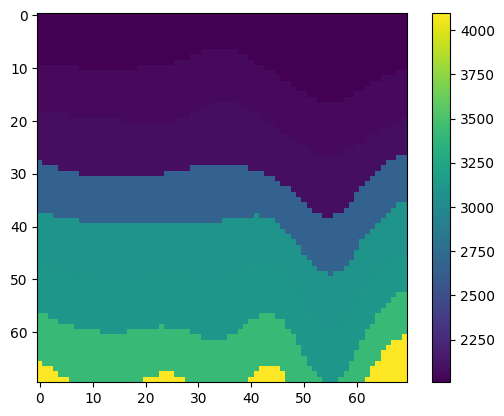

<class 'jaxlib.xla_extension.ArrayImpl'>


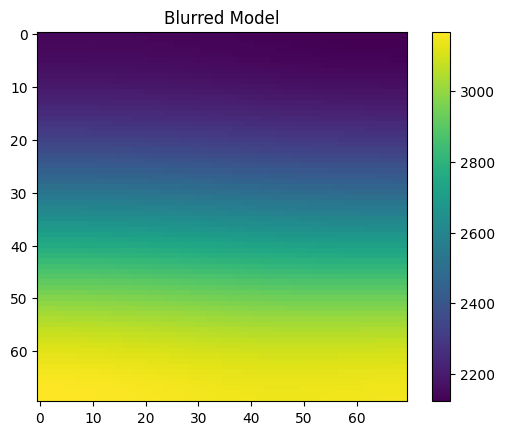

(70, 70)


In [2]:
# Load model

model = jnp.load('model1.npy')


print(model.shape)

model_index = 7

true_model = model[model_index,0,:,:]
plt.imshow(true_model)
plt.colorbar()
plt.show()
print(type(true_model))

from scipy.ndimage import gaussian_filter

# Apply a Gaussian blur
# Adjust sigma as needed; larger sigma = more blur
blurred_model = gaussian_filter(true_model, sigma=20)

# Visualize the blurred model
plt.figure()
plt.imshow(blurred_model, cmap='viridis')
plt.colorbar()
plt.title('Blurred Model')
plt.show()
print(blurred_model.shape)

# homogenous model of the velocity avegare

homogenous_model = jnp.ones(true_model.shape) * jnp.mean(true_model)

# plt.imshow(homogenous_model)

(Array([12, 12, 12, 12, 12, 23, 23, 23, 23, 23, 35, 35, 35, 35, 35, 46, 46,
       46, 46, 46, 57, 57, 57, 57, 57], dtype=int32), Array([12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23,
       35, 46, 57, 12, 23, 35, 46, 57], dtype=int32))


Text(0.5, 1.0, 'Source signals')

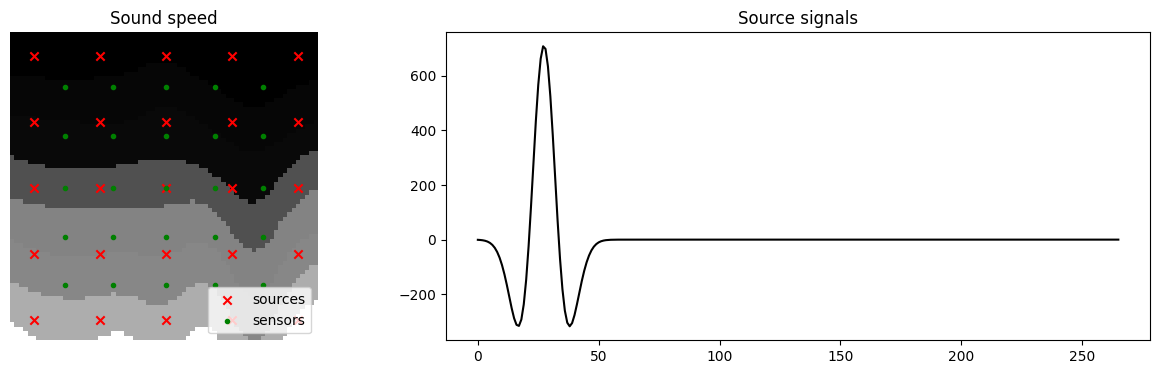

In [3]:
N = (70, 70)  # Grid size
dx = (1.0, 1.0)  # Spatial resolution
cfl=0.75

# Defining the domain
domain = Domain(N, dx)

source_freq = 200
source_mag = 1.3e-1
# source_mag = 1.3

medium = Medium(domain=domain, sound_speed=true_model, density=1000., pml_size=10)

# Time axis
time_axis = TimeAxis.from_medium(medium, cfl=cfl)
t = time_axis.to_array()
source_mag = source_mag / time_axis.dt

s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t + 100)
signal = gaussian_window(apply_ramp(s1, time_axis.dt, source_freq), t, 0.5e-2, 1e-2)

# generate a ricker signal instead of a sinusoidal signal

def ricker_wavelet(t, f, t_shift=0.0):
    """
    Generate a Ricker wavelet with a time shift.

    Parameters:
        t (array-like): Time axis (e.g., jax.numpy array).
        f (float): Central frequency of the wavelet.
        t_shift (float): Time shift for the wavelet (default is 0.0).

    Returns:
        jax.numpy.ndarray: Ricker wavelet values at the given time points.
    """
    t_shifted = t - t_shift  # Apply the time shift
    pi2 = (jnp.pi ** 2)
    a = (pi2 * f ** 2) * (t_shifted ** 2)
    wavelet = (1 - 2 * a) * jnp.exp(-a)
    return wavelet


# Parameters
# source_freq = 25.0  # Central frequency in Hz
# t = jnp.linspace(-0.1, 0.2, 1000)  # Time vector in seconds
t_shift = 0.005  # Time shift in seconds

# Generate the Ricker wavelet with time shift
signal = source_mag * ricker_wavelet(t, source_freq, t_shift)




src_coords_list, receiver_coords_list = generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=5, num_receivers=5)


num_sources = src_coords_list.shape[0]
sensors_positions = (receiver_coords_list[:,0],receiver_coords_list[:,1])
sensors = Sensors(positions=sensors_positions)
source_positions = (src_coords_list[:,0],src_coords_list[:,1])

print(sensors_positions)


# Show comprehensive simulation setup

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})

ax[0].imshow(medium.sound_speed.on_grid, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker=".", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

ax[1].plot(signal, label="Source 1", c="k")
ax[1].set_title("Source signals")
#ax[1].get_yaxis().set_visible(False)

## Setup for the test case C and FWI loss function

In [4]:
fcn_params = {
    "criterion_threshold": 1e-10,
    "regularisation_loss": 0.0,
    "norm_loss": 0.0,
    "top_k_loss": 0.0,
    "differentiable_mask_sharpness": 10.0,
    "number_of_k":10,
    "hidden_size": 56,
    "num_hidden_layers": 3,
    "learning_rate": 1e-3,
    "num_iterations": 15,
    "print_gradients": False,
}

In [5]:
# Load and format the Jacobians

jacobians = jnp.load("curvel_jac_model_{}_data_5_5_5.npy".format(model_index))
print(jacobians.shape)

transposed_jacobians = jnp.transpose(jacobians, axes=(1, 2, 0, 3))

print(transposed_jacobians.shape)
stacked_array = jnp.stack([array.reshape(-1, array.shape[-1]) for array in transposed_jacobians])
stacked_array.shape

# complex_stack_complete = []
# for src in stacked_array:
#     complex_stack = []
#     for row in src:
#         real_part = row.reshape(70,140)[:,:70]
#         imaginary_part = row.reshape(70,140)[:,70:]
#         complex_stack.append(real_part + 1j * imaginary_part)

#     # Convert to NumPy array if needed
#     complex_stack = jnp.array(complex_stack)

#     # print(complex_stack.shape)

#     # Flatten all rows into num_rows x 4900 matrix
#     num_rows = complex_stack.shape[0]
#     complex_reshaped = np.empty((num_rows, 4900), dtype=np.complex128)

#     for i, complex_matrix in enumerate(complex_stack):
#         complex_reshaped[i, :] = complex_matrix.flatten()
    
#     complex_stack_complete.append(complex_reshaped)

# complex_stack_complete = jnp.array(complex_stack_complete)
# print(complex_stack_complete.shape)

# complex_stack_complete_2D = jnp.vstack([array for array in complex_stack_complete])
# print(complex_stack_complete_2D.shape)


(5, 25, 25, 9800)
(25, 25, 5, 9800)


(25, 125, 9800)

In [6]:
# Calculate the eigenvalue criterion for each Jacobian row to serves as input for the network

criterion_threshold = fcn_params["criterion_threshold"]

C_sources_1e_3 = [] 
for array in stacked_array:
    C_sources_1e_3.append(eigenvalue_criterion(array, threshold=criterion_threshold))

C_sources_1e_3 = jnp.array(C_sources_1e_3)

# del stacked_array

<class 'int'>


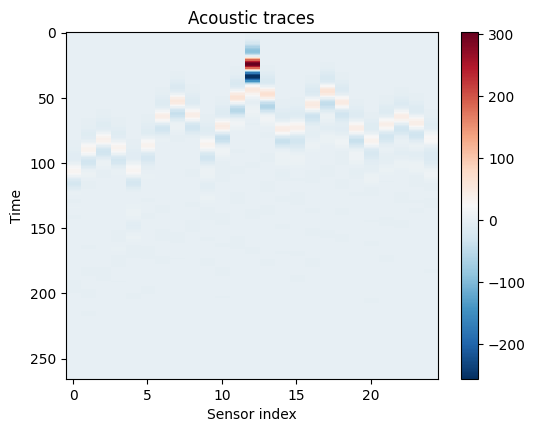

In [7]:
# FWI functions

src_signal = jnp.stack([signal])

@jit
def single_source_simulation(sound_speed, source_num):

        

    # if isinstance(source_num, int):
    x = lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = lax.dynamic_slice(source_positions[1], (source_num,), (1,))
        # print("x, y","int", x,y)

    # else:
    #     x = [source_num[0].astype(jnp.int32)]
    #     y = [source_num[1].astype(jnp.int32)]
    #     print("x, y","array", x,y)
        
    sources = Sources((x, y), src_signal, dt=time_axis.dt, domain=domain)

    # Updating medium with the input speed of sound map
    medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=10)

    # Run simulations
    rf_signals = simulate_wave_propagation(
        medium, time_axis, sources=sources, sensors=sensors, checkpoint=True
    )
    return rf_signals[..., 0]

print(type(num_sources//2))
# print(len(source_trajectories[-1][0]))
p = single_source_simulation(medium.sound_speed, num_sources // 2)
# p = single_source_simulation(medium.sound_speed, source_trajectories[-1][0])
# 
# Visualize the acoustic traces
plt.figure(figsize=(6, 4.5))
maxval = jnp.amax(jnp.abs(p))
plt.imshow(
    p, cmap="RdBu_r", interpolation="nearest", aspect="auto"
)
plt.colorbar()
plt.title("Acoustic traces")
plt.xlabel("Sensor index")
plt.ylabel("Time")
plt.show()

mask = jnp.ones(domain.N)

mask = mask.at[sensors_positions[0], sensors_positions[1]].set(0.0)




def get_sound_speed(params):
    return params + compose(params)(nn.sigmoid) * mask



In [8]:
# # initial model is the blurred model
# params = blurred_model
# # params = homogenous_model
# # params = medium.sound_speed * 0.1 + 
# params

# probabilities = jnp.ones(num_sources)
# # probabilities = jnp.array([0. ,0. ,0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.])

# def hilbert_transf(signal, noise=0.2):
#     x = jnp.abs(analytic_signal(signal))
#     return x


# loss_with_grad = value_and_grad(loss_func, argnums=0)

# batch_simulations = vmap(single_source_simulation, in_axes=(None, 0))
# p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
# print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

# plt.plot(p_data[0, :, 0])
# plt.plot(p_data[1, :, 1])
# plt.show()

# def smooth_fun(gradient):
#     # x = gradient.on_grid[..., 0]
#     x = gradient
#     for _ in range(1):
#         x = smooth(x, 2.0)
#     return x

# loss, gradient = loss_with_grad(params, source_num=2)
# gradient = smooth_fun(gradient)

# # Viualize
# plt.figure(figsize=(8, 6))
# plt.imshow(gradient, cmap="RdBu_r")
# plt.title("Smoothed gradient")
# plt.colorbar()
# plt.show()

# num_steps = 250

# # Define optimizer
# init_fun, update_fun, get_params = optimizers.adam(20.0, 0.9, 0.9)
# opt_state = init_fun(params)



# # Main loop
# pbar = tqdm(range(num_steps))
# _, key = random.split(key)
# batch_size = 10
# num_devices = 12

# reconstructions = []
# losshistory = []

# for k in pbar:
#     _, key = random.split(key)

#     lossval, opt_state = update(opt_state, key, k, probabilities)

#     # Perform update using multiple sources
#     # lossval, opt_state = update_multi(opt_state, key, k)

#     # Perform update using multiple sources in parallel
#     # lossval, opt_state = update_multi_pmap(opt_state, key, k)
    

#     ## For logging
#     new_params = get_params(opt_state)
#     reconstructions.append(get_sound_speed(new_params))
#     losshistory.append(lossval)
#     pbar.set_description("Loss: {}".format(lossval))


# true_sos = true_model
# vmin = np.amin(true_sos)
# vmax = np.amax(true_sos)
# # Visualize the final reconstruction
# reconstructions = jnp.array(reconstructions) 
# plt.figure(figsize=(8, 6))
# plt.imshow(reconstructions[-1], cmap="inferno", vmin=vmin, vmax=vmax)
# plt.colorbar()
# plt.title("Final reconstruction")
# plt.show()

In [9]:
# Fully Connected Neural Network
class FullyConnectedNN(eqx.Module):
    layers: list
    activations: list

    def __init__(self, input_size, hidden_size, num_hidden_layers, key):
        keys = jax.random.split(key, num_hidden_layers + 1)
        self.layers = [eqx.nn.Linear(input_size, hidden_size, key=keys[0])] + \
                      [eqx.nn.Linear(hidden_size, hidden_size, key=k) for k in keys[1:-1]] + \
                      [eqx.nn.Linear(hidden_size, input_size, key=keys[-1])]
        
        self.activations = [jax.nn.tanh] * num_hidden_layers + [jax.nn.sigmoid]

    def __call__(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        return x

# Differentiable Mask
def differentiable_mask(probabilities, sharpness=10.0):
    return jax.nn.sigmoid(sharpness * (probabilities - 0.5))

# def top_k_regularization(soft_mask, k=10):
#     top_k_values = jax.lax.top_k(soft_mask, k)[0]
#     penalty = jnp.sum(soft_mask) - jnp.sum(top_k_values)
#     return penalty

def fwi(probabilities):
    
    # _, key = random.split(key)
    # initial model is the blurred model
    params = blurred_model
    init_fun, update_fun, get_params = optimizers.adam(20.0, 0.9, 0.9)
    opt_state = init_fun(params)

    print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

    def loss_func(params, source_num):
        c0 = get_sound_speed(params)
        p = single_source_simulation(c0, source_num)
        data = p_data[source_num]
        # return jnp.mean(jnp.abs(hilbert_transf(p) -hilbert_transf(data)) ** 2)
        # L2 loss
        return jnp.mean((p - data) ** 2)

    loss_with_grad = value_and_grad(loss_func, argnums=0)

    # Define and compile the update function
    # @jit
    def update(opt_state, key, k, probabilities):
        v = get_params(opt_state)
        src_num = random.choice(key, num_sources)
        lossval, gradient = loss_with_grad(v, src_num)
        # gradient = smooth_fun(gradient)
        gradient *= probabilities[src_num]
        return lossval, update_fun(k, gradient, opt_state)

    for k in range(55):

        lossval, opt_state = update(opt_state, key, k, probabilities)

        ## For logging
        new_params = get_params(opt_state)
    
    return new_params



# Differentiable Loss Function
def differentiable_loss_fn(model, x, criterion_threshold ,sharpness=10.0, mask_penalty=0.1):
    probabilities = model(x)  # Predict probabilities
    soft_mask = differentiable_mask(probabilities, sharpness)  # Generate soft mask
    
    

    # multiplier = matrix.shape[0] // soft_mask.shape[0]
    # soft_mask = jnp.repeat(soft_mask, multiplier, axis=0)

    # weighted_matrix = soft_mask[:, None] * matrix  # Apply mask to matrix rows

    regularization_loss = mask_penalty * jnp.mean(soft_mask * (1 - soft_mask))  # Encourage binary mask
    norm_loss = jnp.linalg.norm(soft_mask, ord=1)
    # top_k_loss = top_k_regularization(soft_mask, k=fcn_params["number_of_k"])

    # singular_loss = eigenvalue_criterion(weighted_matrix, threshold=criterion_threshold)
    inverted_model = fwi(probabilities)
    
    fwi_loss = jnp.linalg.norm(inverted_model - true_model, ord=1)



    # return -(singular_loss) + params["regularisation_loss"]*regularization_loss + params["norm_loss"]*norm_loss + params["top_k_loss"]*top_k_loss
    return fwi_loss + fcn_params["regularisation_loss"]*regularization_loss + fcn_params["norm_loss"]*norm_loss 



In [10]:
# Example Usage
key = jax.random.PRNGKey(42)
input_size = C_sources_1e_3.shape[0]
hidden_size = fcn_params["hidden_size"]
num_hidden_layers = fcn_params["num_hidden_layers"]
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)

print("Model:", model)

# matrix = jax.random.normal(key, (100, 50))  # Matrix with 100 rows and 50 columns
# matrix = complex_stack_complete_2D
# x = jax.random.normal(key, (input_size,))  # Input to the network
x = C_sources_1e_3
# x = (x - jnp.mean(x)) / jnp.std(x)
x = (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))

Model: FullyConnectedNN(
  layers=[
    Linear(
      weight=f32[56,25],
      bias=f32[56],
      in_features=25,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[25,56],
      bias=f32[25],
      in_features=56,
      out_features=25,
      use_bias=True
    )
  ],
  activations=[
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function sigmoid>
  ]
)


In [11]:
def train_step(model, criterion_threshold, optimizer, opt_state, x, logs):
    # Compute loss and gradients
    loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)
    loss, grads = loss_and_grad_fn(model, x, criterion_threshold=criterion_threshold, sharpness=fcn_params["differentiable_mask_sharpness"], mask_penalty=1.0)
    
    if fcn_params["print_gradients"]:  
        jax.tree_util.tree_map(lambda g: print("Gradient shape:", g.shape, "Gradient values:", g), grads)
        jax.tree_util.tree_map(lambda g: print(f"Gradient shape: {g.shape}, Min: {jnp.min(g)}, Max: {jnp.max(g)}, Mean: {jnp.mean(g)}"), grads)

    # Update optimizer state and model
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)

    # Log the network output (predicted probabilities)
    probabilities = model(x)  # Network output
    logs["probabilities"].append(probabilities)

    # Log the mask M
    soft_mask = differentiable_mask(probabilities, sharpness=fcn_params["differentiable_mask_sharpness"])  # Differentiable mask
    logs["masks"].append(soft_mask)

    return loss, model, opt_state

Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 0, Loss: 40283.58984375
Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 1, Loss: 40247.64453125
Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 2, Loss: 40153.8984375
Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 3, Loss: 40093.05078125
Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 4, Loss: 40010.5390625
Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 5, Loss: 39881.5546875
Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 6, Loss: 39760.9921875
Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 7, Loss: 39592.8203125
Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 8, Loss: 39443.046875
Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 9, Loss: 39243.27734375
Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)
Step 10, Loss: 39042.9921875
Size of data [Source idx, Time, Sensor 

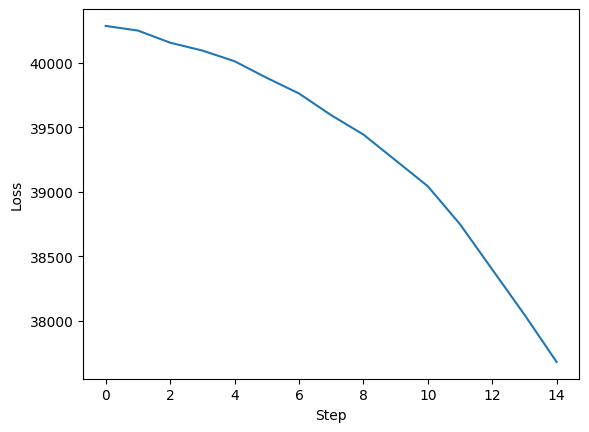

In [12]:

# Initialize the model and optimizer
key = jax.random.PRNGKey(42)
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)
optimizer = optax.adamw(fcn_params["learning_rate"])  # Adam optimizer
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))  # Initialize optimizer state
initial_predictions = model(x)  # Initial predictions

batch_simulations = vmap(single_source_simulation, in_axes=(None, 0))
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))

# Training loop
num_steps = fcn_params["num_iterations"]
losses = []
logs = {"probabilities": [], "masks": []}
for step in range(num_steps):
    loss, model, opt_state = train_step(model, criterion_threshold, optimizer, opt_state, x, logs)
    losses.append(loss)

    if step % 1 == 0:
        print(f"Step {step}, Loss: {loss}")

# Plot the losses
plt.figure()
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

Step 0: Probabilities: [0.5553395  0.51171356 0.47121218 0.52197    0.50364417 0.5077572
 0.48500478 0.4843656  0.50526565 0.5109602  0.48427132 0.4862319
 0.5210497  0.5824234  0.53993887 0.48326185 0.49235532 0.47492748
 0.49135742 0.5027568  0.4633214  0.47618428 0.5172215  0.5008565
 0.43816173]
Step 0: Mask: [0.6349229  0.5292505  0.42852342 0.5547051  0.50910944 0.51938325
 0.46258205 0.46099347 0.5131611  0.52737314 0.46075916 0.465634
 0.55243075 0.69513434 0.5985408  0.45825204 0.48089758 0.43764502
 0.47840697 0.5068915  0.40931785 0.44074053 0.5429477  0.5021413
 0.35014936]
Step 1: Probabilities: [0.55165917 0.5096723  0.4667907  0.5212602  0.5096544  0.5065689
 0.48414338 0.48322177 0.5096395  0.5114617  0.4820833  0.48698196
 0.53192645 0.59207714 0.53249204 0.48220676 0.4852738  0.47575936
 0.49052447 0.5024439  0.4579963  0.47665548 0.5137777  0.49930194
 0.40997446]
Step 1: Mask: [0.62635046 0.5241619  0.4177315  0.5529512  0.5241173  0.5164164
 0.46044132 0.45815253 0

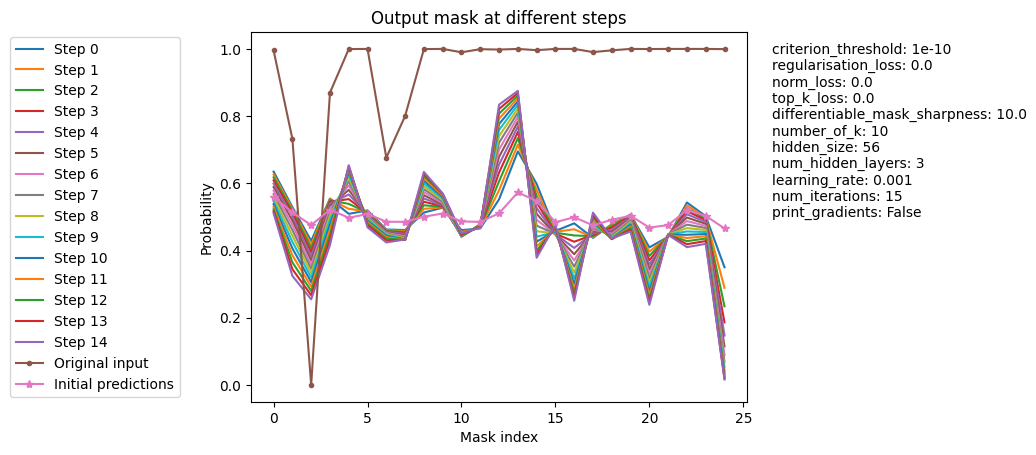

In [16]:
# Print the first few steps for inspection
for i, (probs, mask) in enumerate(zip(logs["probabilities"], logs["masks"])):
    print(f"Step {i}: Probabilities: {probs}")
    print(f"Step {i}: Mask: {mask}")
    if i > 5:  # Limit to first few steps for readability
        break

# Example: Plot the first mask at different training steps
steps_to_plot = [i for i in range(num_steps)]  # Select steps to visualize
plt.figure()

for step in steps_to_plot:
    plt.title(f"Output mask at different steps")
    plt.plot(logs["masks"][step], label=f"Step {step}")
    # plt.colorbar(label="Mask Values")
    plt.xlabel("Mask index")
    plt.ylabel("Probability")

plt.plot(x, ".-", label="Original input")
plt.plot(initial_predictions,"*-", label="Initial predictions")
# put the legend outside of the graph, to the left
plt.legend(loc='center left', bbox_to_anchor=(-0.5, 0.5))

# add the params dictionary to the plot, on the right, one key per line
plt.text(1.05, 0.5, '\n'.join([f"{key}: {value}" for key, value in fcn_params.items()]), transform=plt.gca().transAxes)

plt.show()

In [17]:
final_mask = logs["masks"][-1]
best_sources_C = jnp.argsort(final_mask)[-10:]
print("best source index", best_sources_C)

best source index [11  5 15  0 17  9  8  4 12 13]


In [15]:
# model = fwi(final_mask)